In [120]:
import re
import random
!pip install pymorphy3
import pymorphy3

import numpy as np
import pandas as pd
import openpyxl

import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.text as text
import matplotlib.cm as cm
%matplotlib inline

# Нужно раскоментировать чтобы работало построение разного рода графиков,
# но тогда на матрице ошибок возникают лишние линии
import seaborn as sns; sns.set()

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV


In [121]:
import itertools
pd.options.display.width = 0
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 11)

In [78]:
df = pd.read_excel('mails.xlsx')
print(df['class'].unique())
df['TYPE_HOTLINE'].unique()


[1 6 5 2 3 4 8 7]


array([2, 1, 3])

In [79]:
# Меняем наименование столбца только для удобства
df.rename(columns={'CLASS_': 'lbl'}, inplace=True)
# Для удобства добавляем два столбца с наименованиями классов и каналов поствупления обращений.
cls_dic = {1:['Условия подачи','Условия подачи документов, сроки, документы, места, льготы'],
           2:['Проходной и допустимый балл','Минимальный проходной балл и Минимальный балл для подачи заявления'],
           3:['Достижения','Индивидуальные достижения.'],
           4:['Общежития','Общежития'],
           5:['Вступительные испытания','Вступительные испытания, экзамены, кто может поступать и сдавать экзамены'],
           6:['Перевод','Перевод с направления на направление'],
           7:['Аспирантура','Вопросы по аспирантуре'],
           8:['Регистрация','Регистрация в электронных системах'],
           }
hlt_dic = {1:'ONLINE приёмная',
           2:'Очная приемная',
           3:'Приёмная аспирантуры'
           }

df['cls_name'] = df['class'].map(lambda x: cls_dic[x][0])
df['hlt_name'] = df.TYPE_HOTLINE.map(lambda x: hlt_dic[x])
df.head()

,CONTENT,TYPE_HOTLINE,class,cls_name,hlt_name
0,Здравствуйте! Поступила в ваш институт на бюдж...,2,1,Условия подачи,Очная приемная
1,Здравствуйте! Я прошла конкурс по трем дисципл...,2,6,Перевод,Очная приемная
2,Здравствуйте! Скажите пожалуйста могу ли я под...,2,1,Условия подачи,Очная приемная
3,Здравствуйте! Где взять и куда подать заявлени...,2,1,Условия подачи,Очная приемная
4,Здравствуйте! Есть два высших образования (пла...,2,1,Условия подачи,Очная приемная


In [80]:
cls_list = []
for i in range(1,len(cls_dic)+1):
  cls_list.append(cls_dic[i][0])

In [81]:
df.shape

(588, 5)

### Анализ, визуализация и сбалансированность датасета

cls_name
Аспирантура                      5
Вступительные испытания        155
Достижения                      29
Общежития                       28
Перевод                         42
Проходной и допустимый балл     24
Регистрация                     16
Условия подачи                 289
Name: cls_name, dtype: int64


<Axes: ylabel='cls_name'>

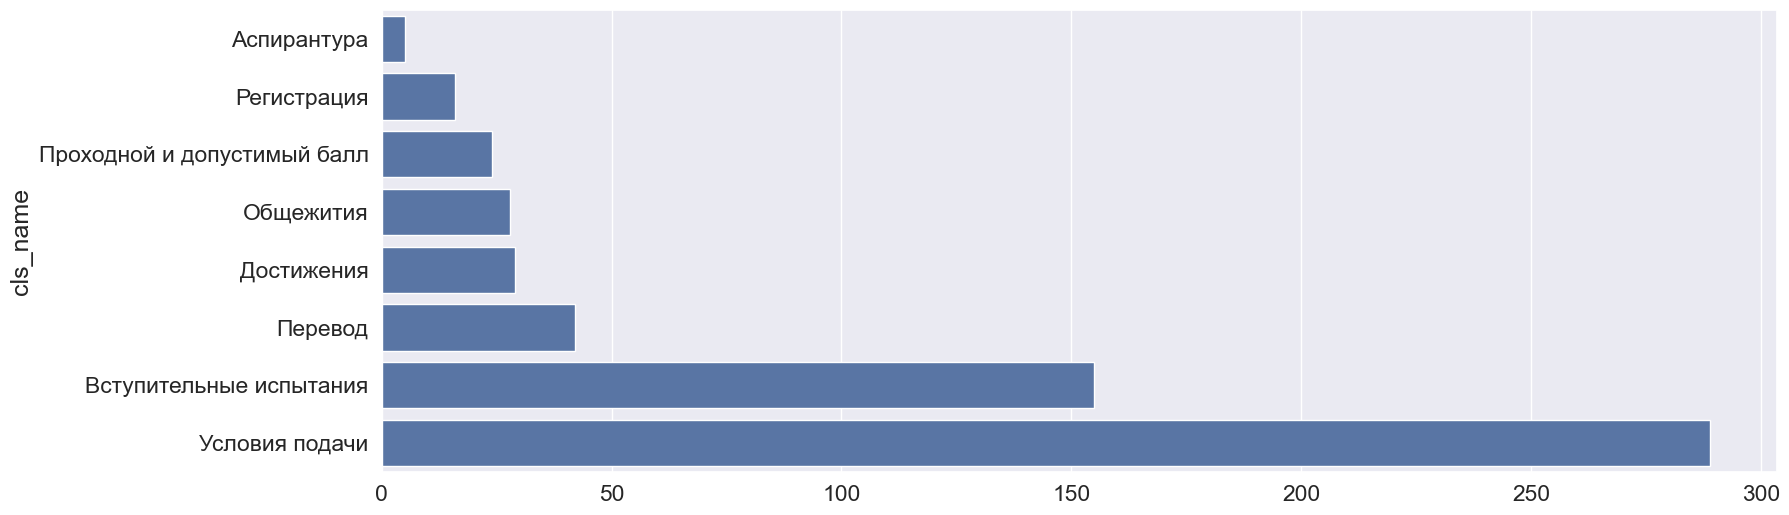

In [82]:
g = df.groupby('cls_name')['cls_name'].count().sort_values()
print(df.groupby('cls_name')['cls_name'].count())
sns.set(font_scale=1.5)
f, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x=g.values, y=g.index, orient='h')
#f.savefig('Data\\fig_1.png', bbox_inches='tight')

<Axes: ylabel='TYPE_HOTLINE'>

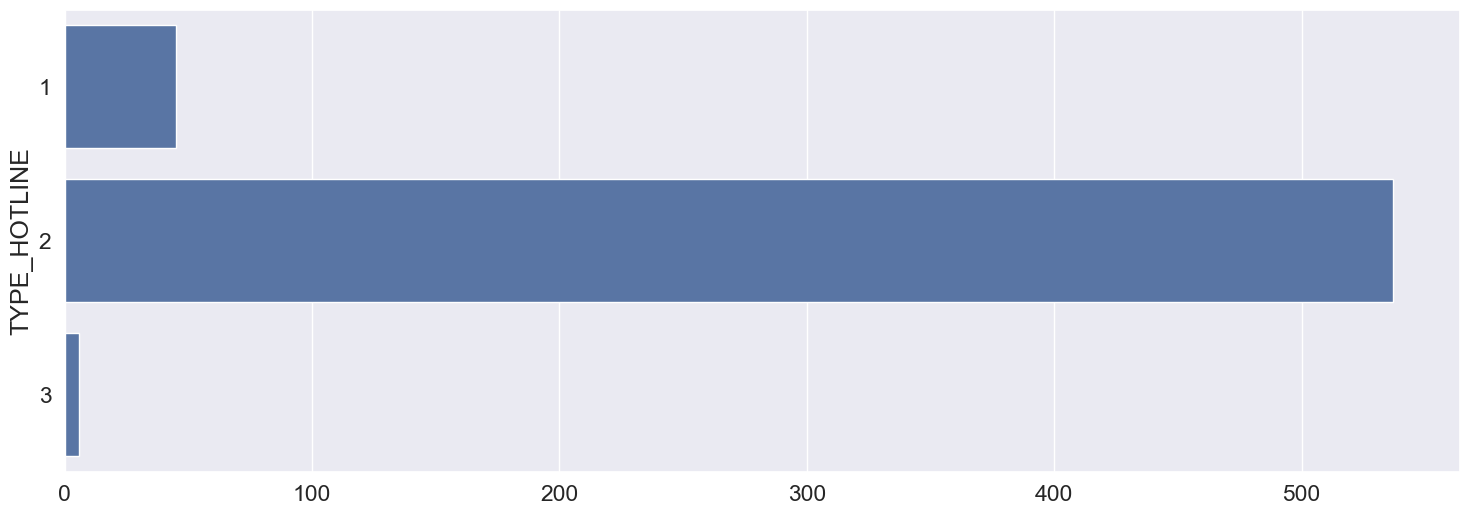

In [83]:
g = df.groupby('TYPE_HOTLINE')['TYPE_HOTLINE'].count().sort_values()
sns.set(font_scale=1.5)
f, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x=g.values, y=g.index, orient='h')

# Задача 1. Подготовка данных
Предобработка текста писем: удаление из текста лишней информации, которая не нужна для получения основной мысли сообщения и классификации его.

In [84]:
# Функция для удаления знаков препинания
def del_punct(word):
    return re.sub(r'[^\w\s]', '', word)

# Функция для удаления стоп-слов
def remove_stopwords(text, stopwords):
    return ' '.join([word for word in text.split() if word not in stopwords])



#### Приведение слов в нормальную форму

In [85]:
# Функция для обработки каждого слова
def morphan(word, morph, stopwords):
    '''
    Приведение слов в нормальную форму, удаление числительных и ФИО.
    '''
    word = del_punct(word).strip().lower()  # Приводим к нижнему регистру и убираем знаки препинания
    p = morph.parse(word)[0]

    word_new = word
    if (not 'Surn' in p.tag) and (not 'Name' in p.tag) and (not 'Patr' in p.tag) and ('NOUN' in p.tag):
        # существительное не ФИО
        word_new = p.normal_form
    elif 'Surn' in p.tag:
        word_new = 'ФАМИЛИЯ'
    elif 'Name' in p.tag:
        word_new = 'ИМЯ'
    elif 'Patr' in p.tag:
        word_new = 'ОТЧЕСТВО'
    elif ('INFN' in p.tag) or ('VERB' in p.tag):  # глагол
        word_new = p.normal_form
    elif ('ADJF' in p.tag) or ('ADJS' in p.tag) or ('COMP' in p.tag):  # прилагательное
        word_new = p.normal_form
    elif ('PRTF' in p.tag) or ('PRTS' in p.tag) or ('GRND' in p.tag):  # причастие
        word_new = p.normal_form
    elif ('ADVB' in p.tag) or ('NPRO' in p.tag) or ('PRED' in p.tag) or ('PREP' in p.tag) or ('CONJ' in p.tag) or ('PRCL' in p.tag) or ('INTJ' in p.tag):
        # предлоги, местоимения и пр.
        word_new = p.normal_form
    elif ('NUMR' in p.tag) or ('NUMB' in p.tag) or ('intg' in p.tag):  # числительные
        word_new = ''
    else:
        word_new = word
    return word_new

# Функция нормализации текста
def normtext(txt, morph, stopwords):
    '''
    Возвращает текст из слов в нормальной форме, удаляет лишнюю информацию.
    '''
    # Убираем стоп-слова перед нормализацией
    txt = remove_stopwords(txt, stopwords)
    return str(' '.join([morphan(x, morph, stopwords) for x in txt.split()]))

# Загрузка стоп-слов (например, из NLTK или других источников)
stopwords = set([
    'и', 'в', 'во', 'не', 'что', 'на', 'с', 'как', 'по', 'за', 'то', 'его', 'себя', 'она', 'для', 'мы', 'вы',
    'он', 'оно', 'они', 'к', 'у', 'от', 'до', 'о', 'это', 'так', 'все', 'там', 'бы', 'весь', 'ещё', 'также'
])


In [86]:
morph = pymorphy3.MorphAnalyzer()

In [87]:
df['text'] = df['CONTENT'].map(lambda x: normtext(x, morph, stopwords))

In [88]:
# Сохраняем обработанные данные
df.to_excel('df_prep.xlsx', index=False)

# Задача 2. ML - Классификация
Основная задача (обязательная для решения). Разработать программу для классификации обращений (писем).

In [90]:
# Т.к. вопрорсов по аспирантуре мало, и в них в основном встречается подстрока 'аспирант', то можно записи проклассифицировать по наличию этой подстроки

def find_aspirant(txt):
    '''
    Возвращает True если в тексте есть слово, начинающееся на 'аспирант'
    '''
    return 'аспирант' in [x[:8] for x in txt.split()]

#### Подбор параметра

In [122]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df['class'], random_state=42, test_size=0.3)

tfv = TfidfVectorizer()  # Функция получения векторного представления
X_train = tfv.fit_transform(X_train)
X_test = tfv.transform(X_test)

param_grid = {'C': [1.,10.0]}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=3)

grid_search.fit(X_train, y_train)

grid_search.score(X_test, y_test)

grid_search.best_params_

{'C': 10.0}

{'C': 10.0}

In [123]:
def classifier(X_train, y_train, C=10.):
    '''
    Возвращает обученный классификатор и векторизатор.
    '''

    tfv = TfidfVectorizer()
    X_train = tfv.fit_transform(X_train)

    clf = LogisticRegression(C=C)
    clf = clf.fit(X_train, y_train)

    return tfv, clf

def predictor(text, clf, tfv):
    '''
    text - классифицируемый текс
    clf - обученный классификатор
    tfv - обученный векторизатор

    '''
    X_test = tfv.transform([text])

    pred = clf.predict(X_test)

    return pred[0]

In [124]:
# Обучение
X_train, X_test, y_train, y_test = train_test_split(df.text, df['class'], random_state=42, test_size=0.3)
tfv, clf = classifier(X_train, y_train, C=10.0)

In [94]:
# Предсказание
pred_save = []
class_save = []
pred = []
print(X_test.shape)
for nom, txt in enumerate(X_test.values):
    if find_aspirant(txt):
        # УДАЛЕНИЕ "аспирант" по подстроке
        pred_save.append(7)
        del_index = X_test.index.to_numpy()[nom]
        X_test = X_test.drop(index=[del_index])
        class_save.append(y_test[y_test.index==del_index].values[0])
        y_test = y_test.drop(index=[del_index])
    else:
        pred.append(predictor(txt, clf, tfv))
print(X_test.shape)


(177,)
(176,)


In [95]:
y_test_list = y_test.tolist()
y_test_list.extend(class_save)
pred_list = pred[:]
pred_list.extend(pred_save)

mtrs = metrics.classification_report([cls_dic[x][0] for x in y_test_list], [cls_dic[x][0] for x in pred_list])
print(mtrs)

                             precision    recall  f1-score   support

                Аспирантура       1.00      1.00      1.00         1
    Вступительные испытания       0.95      0.84      0.89        49
                 Достижения       0.71      0.62      0.67         8
                  Общежития       0.50      1.00      0.67         5
                    Перевод       1.00      0.33      0.50         6
Проходной и допустимый балл       1.00      0.36      0.53        11
                Регистрация       1.00      0.25      0.40         8
             Условия подачи       0.80      0.97      0.87        89

                   accuracy                           0.82       177
                  macro avg       0.87      0.67      0.69       177
               weighted avg       0.86      0.82      0.81       177



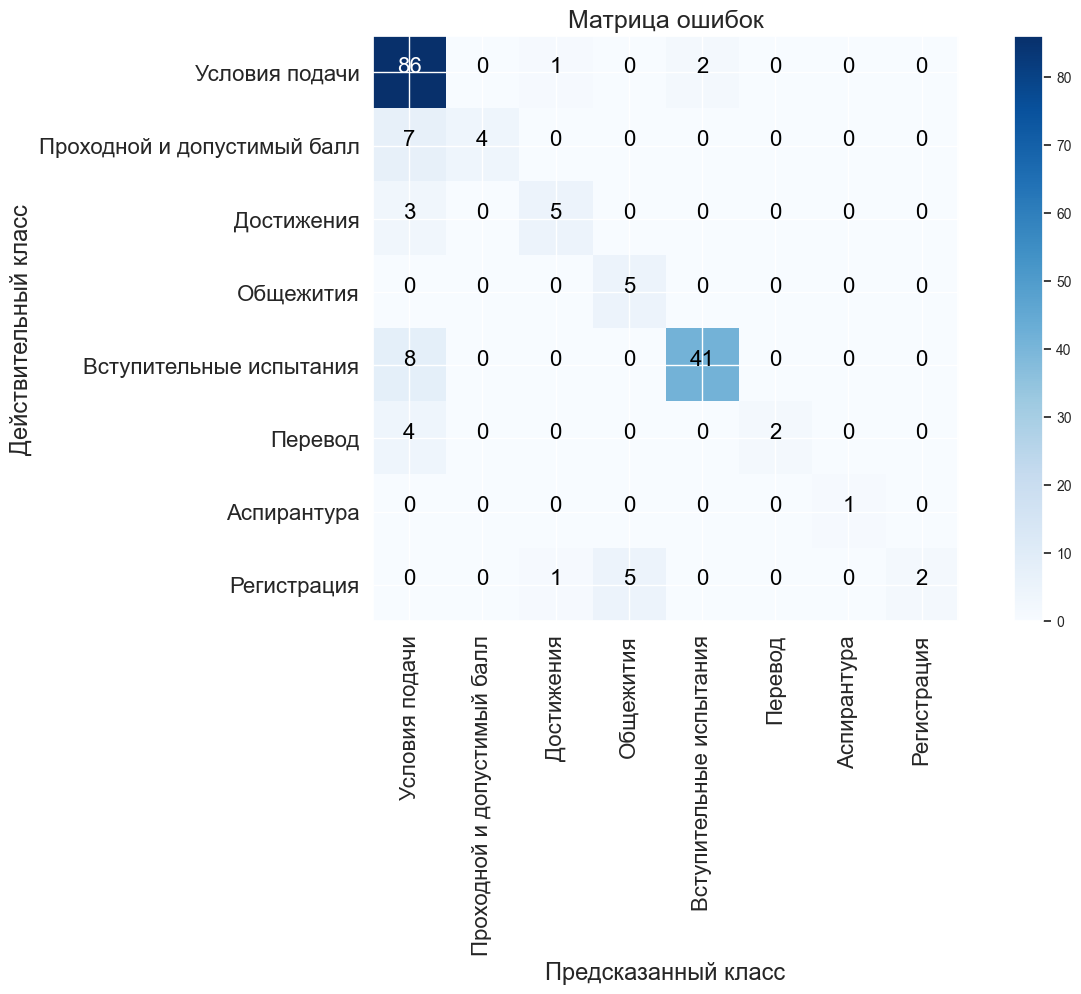

In [96]:
def plot_confusion_matrix(cm, classes, f_size=16, normalize=False, title='Матрица ошибок', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'
    """
    plt.figure(figsize=(14,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=f_size + 2)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=f_size - 6)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=f_size)
    plt.yticks(tick_marks, classes, fontsize=f_size)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print("Confusion matrix, without normalization")

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=f_size)
    plt.tight_layout()
    plt.ylabel('Действительный класс', fontsize=f_size + 1)
    plt.xlabel('Предсказанный класс', fontsize=f_size + 1)
    plt.show()

# conf_matr = confusion_matrix(y_test_list, pred_list, normalize='true')
conf_matr = confusion_matrix(y_test_list, pred_list)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

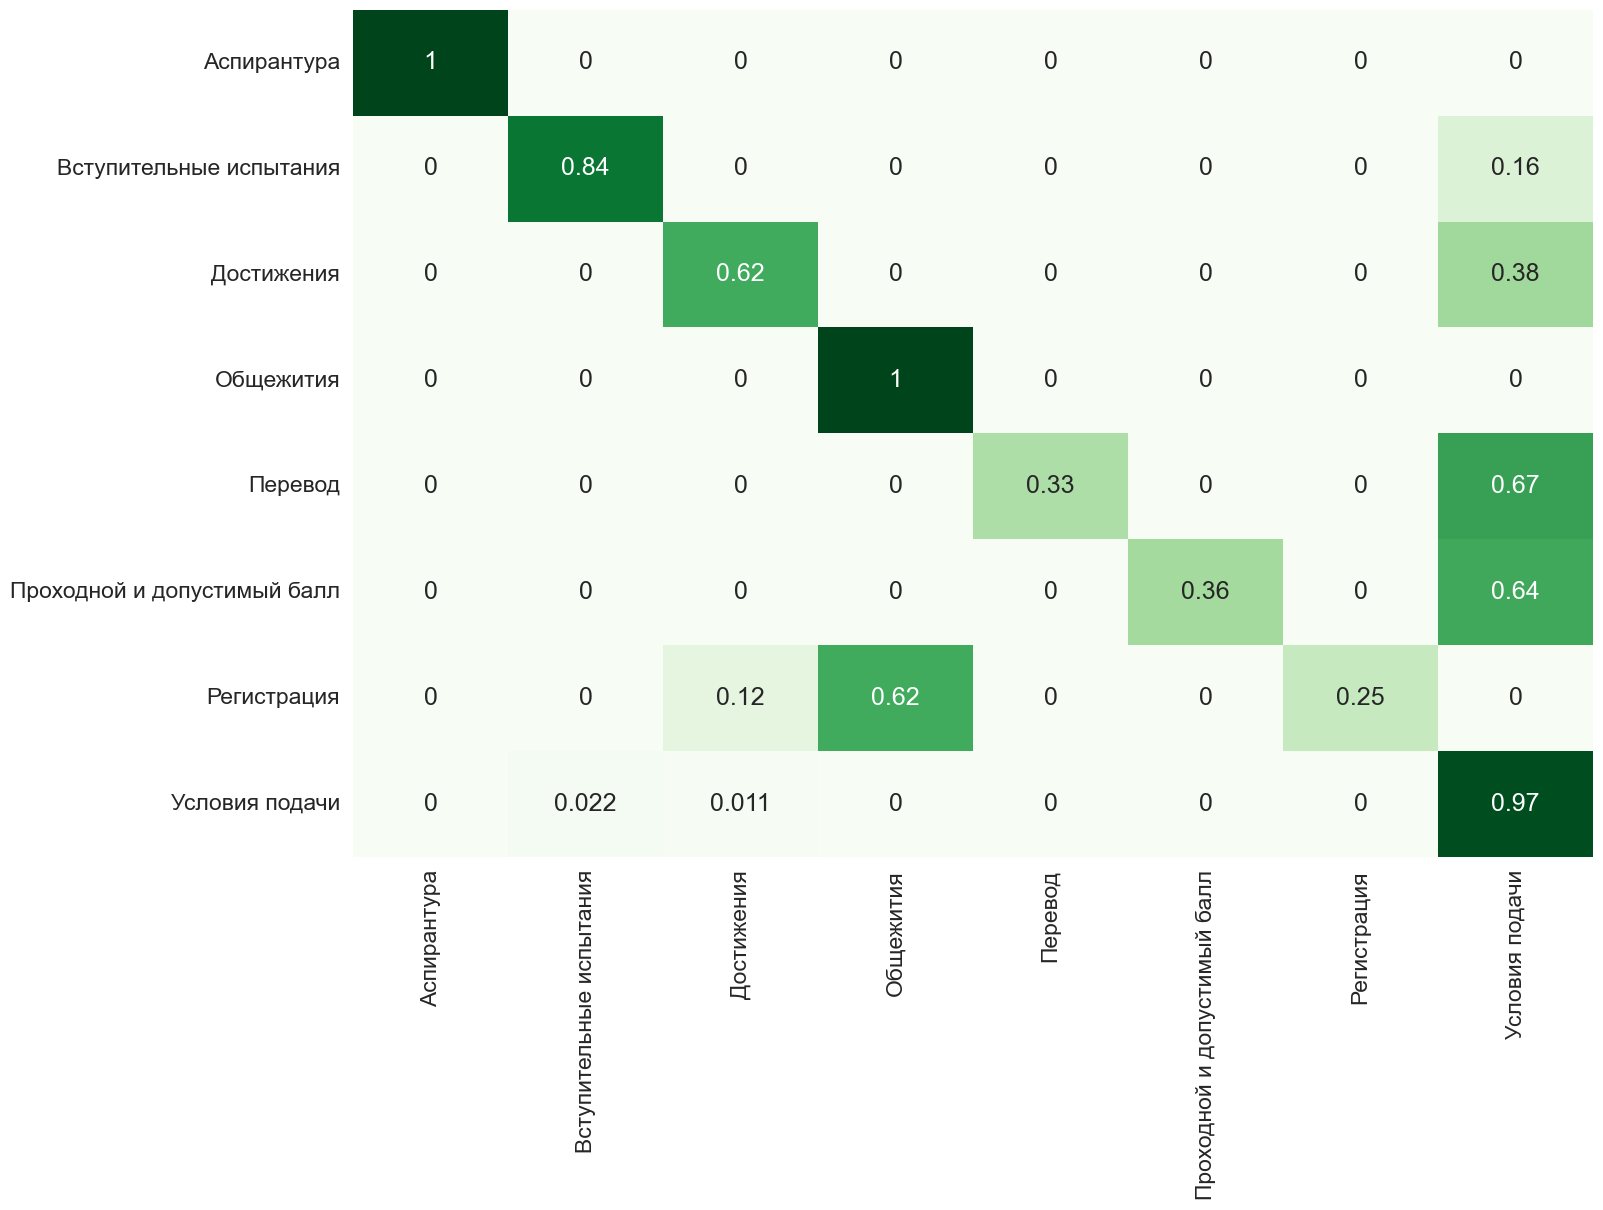

In [119]:
y_te = [cls_dic[i][0] for i in y_test_list]
y_pr = [cls_dic[i][0] for i in pred_list]
mat = confusion_matrix(y_te, y_pr, normalize='true')
mat = pd.DataFrame(mat, index=np.unique(y_te), columns=np.unique(y_pr))

f, ax = plt.subplots(figsize=(16, 11))
sns_plot = sns.heatmap(mat, annot=True, cbar=False, cmap="Greens")

# Задача 3. RNN - классификация

In [116]:
! pip install tensorflow
#! pip uninstall keras keras-nightly keras-preprocessing keras-applications -y
! pip install --upgrade tensorflow
! pip install tensorflow==2.18.0 --ignore-installed

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding, LSTM



  Obtaining dependency information for tensorflow==2.18.0 from https://files.pythonhosted.org/packages/dc/bf/4cc283db323fd723f630e2454b2857054d2c81ff5012c1857659e72470f1/tensorflow-2.18.0-cp312-cp312-macosx_12_0_arm64.whl.metadata
  Using cached tensorflow-2.18.0-cp312-cp312-macosx_12_0_arm64.whl.metadata (4.0 kB)
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl.metadata
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Obtaining dependency information for flatbuffers>=24.3.25 from https://files.pythonhosted.org/packages/41/f0/7e988a019bc54b2d

# LSTM

In [117]:
# создаем единый словарь (слово -> число) для преобразования
tokenizer = Tokenizer()
print(X_train)
tokenizer.fit_on_texts(X_train)

# Преобразуем все описания в числовые последовательности, заменяя слова на числа по словарю.
textSequences = tokenizer.texts_to_sequences(X_train)

[[   0    0    0 ...   10   15    4]
 [   0    0    0 ...   97 1223   68]
 [   0    0    0 ...  133  155   25]
 ...
 [   0    0    0 ...   64   25  348]
 [   0    0    0 ...   20   25  268]
 [   0    0    0 ...  296   10  949]]


AttributeError: 'numpy.ndarray' object has no attribute 'lower'

In [118]:
X_train_1, X_valid_test_1, y_train_1, y_valid_test_1 = train_test_split(df.text, df['class'], random_state=42, test_size=0.3)
X_valid_1, X_test_1, y_valid_1, y_test_1 = train_test_split(X_valid_test_1, y_valid_test_1, test_size=0.5, random_state=42)


In [101]:
# Максимальное количество слов в самом длинном письме
max_words = 0
for desc in df.text.tolist():
    words = len(desc.split())
    if words > max_words:
        max_words = words
print('Максимальное количество слов в самом длинном письме: {} слов'.format(max_words))

total_unique_words = len(tokenizer.word_counts)
print('Всего уникальных слов в словаре: {}'.format(total_unique_words))

maxSequenceLength = max_words

Максимальное количество слов в самом длинном письме: 87 слов
Всего уникальных слов в словаре: 1315


In [102]:
# Задаем размер словаря
vocab_size = len(tokenizer.word_index) + 1  # Уникальные слова + 1 для паддинга

# Определяем размер словаря
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df.text)

# Преобразуем текст в последовательности
X_train = tokenizer.texts_to_sequences(X_train_1)
X_valid = tokenizer.texts_to_sequences(X_valid_1)
X_test = tokenizer.texts_to_sequences(X_test_1)

# Выполняем паддинг
X_train = sequence.pad_sequences(X_train, maxlen=maxSequenceLength)
X_valid = sequence.pad_sequences(X_valid, maxlen=maxSequenceLength)
X_test = sequence.pad_sequences(X_test, maxlen=maxSequenceLength)

print('Размерность X_train:', X_train.shape)
print('Размерность X_valid:', X_valid.shape)
print('Размерность X_test:', X_test.shape)

# Преобразуем категории в матрицу двоичных чисел
num_classes = df['class'].unique().shape[0] + 1

y_train = keras.utils.to_categorical(y_train_1, num_classes)
y_valid = keras.utils.to_categorical(y_valid_1, num_classes)
y_test = keras.utils.to_categorical(y_test_1, num_classes)

print('y_train shape:', y_train.shape)
print('y_valid shape:', y_valid.shape)
print('y_test shape:', y_test.shape)


Размерность X_train: (411, 87)
Размерность X_valid: (88, 87)
Размерность X_test: (89, 87)


NameError: name 'keras' is not defined

In [248]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print (model.summary())

Собираем модель...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [249]:
batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

Тренируем модель...
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.3431 - loss: 2.1685 - val_accuracy: 0.5000 - val_loss: 2.0278
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4925 - loss: 1.9330 - val_accuracy: 0.5000 - val_loss: 1.5058
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4838 - loss: 1.5432 - val_accuracy: 0.5000 - val_loss: 1.4628
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4510 - loss: 1.5402 - val_accuracy: 0.5000 - val_loss: 1.4441
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4958 - loss: 1.4154 - val_accuracy: 0.5000 - val_loss: 1.4300
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5302 - loss: 1.3772 - val_accuracy: 0.5000 - val_loss: 1.3885
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5712 - loss: 1.2824 - val_accuracy: 0.5568 - val_loss: 1.3151
Epoch 8/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5968 - loss: 1.2717 - val_

In [250]:
predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


In [251]:
print(classification_report(y2, pred2))

              precision    recall  f1-score   support

           1       0.76      0.87      0.81        45
           2       0.00      0.00      0.00         3
           3       0.40      0.50      0.44         4
           4       0.17      0.50      0.25         2
           5       0.91      0.84      0.88        25
           6       0.25      0.25      0.25         4
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         5

    accuracy                           0.72        89
   macro avg       0.31      0.37      0.33        89
weighted avg       0.68      0.72      0.69        89



c:\Users\tiopt\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tiopt\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tiopt\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo